# Noyau signature vs Signature

In [4]:
import iisignature as iis
import numpy as np
import time

In [5]:
m = 7
series = np.random.rand(10, 20, 3)
true_graam = np.zeros((10, 10))

In [6]:
def k(x,y):
    return x@y.T

## Algorithmes
L'algorithme du premier ordre approxime la signature avec des différences finis. 

$\displaystyle \prod_{i =1}^{l-1} \nabla k_{x_i} \simeq (\int dk_ {x}^{\otimes m} )_{m \geq 0}$

Qui est à la base de la signature discrétisée $S^+$

L'algorithme aux ordres suivants est une généralisation aux tenseurs d'ordres supérieurs : 
$\displaystyle \prod_{i =1}^{l-1} \sum_{j=0}^{d} \frac{(\nabla k_{x_i})^{\otimes j }}{j!} \simeq (\int dk_ {x}^{\otimes m} )_{m \geq 0}$




In [7]:
def signature_kernel_first_order(a,b,m):
    K = a@b.T
    K = np.diff(np.diff(K, axis=0), axis=1)
    A = np.copy(K)
    for i in range(1,m):
        Q = np.cumsum(np.cumsum(A, axis=0), axis=1)
        Q = np.roll(np.roll(Q, 1, axis=0), 1, axis=1) 
        Q[:, 0] = 0
        Q[0, :] = 0
        A = K * (1 + Q)
    return 1 + np.sum(np.sum(A, axis=1), axis=0)

In [8]:
def signature_kernel_higher_order(a,b,m,o):
    K = a@b.T
    K = np.diff(np.diff(K, axis=0), axis=1)
    A = np.zeros((m+1, o+1, o+1, len(a)-1, len(b)-1))
    
    for n in range(1,m+1):
        d = min(o+1, n)
        
        Q = np.cumsum(np.cumsum(A[n-1, :, :, :, :], axis=2), axis=3)
        Q = np.roll(np.roll(Q, 1, axis=2), 1, axis=3)
        Q[:,:,:,0] = 0
        Q[:,:,0,:] = 0
        Q = np.sum(Q, axis=(0,1))
        A[n,0,0,:,:] = K*(1.+Q)
        for r in range(1, d):
            Q = np.cumsum(A[n-1, r-1, :, :, :], axis=2)
            Q = np.roll(Q, 1, axis=2)
            Q[:,:,0] = 0
            Q = np.sum(Q, axis=0)
            A[n,r,0,:,:] = (1./(r+1))*K*Q
            
            Q = np.cumsum(A[n-1, :, r-1, :, :], axis=1)
            Q = np.roll(Q, 1, axis=1)
            Q[:,0,:] = 0
            Q = np.sum(Q, axis=0)
            A[n,0,r,:,:] = (1./(r+1))*K*Q
            for s in range(1,d):
                A[n,r,s,:,:] = (1./((r+1)*(s+1))) * K * A[n-1,r-1,s-1,:,:]
    return 1. + np.sum(A[m,:,:,:,:])

In [9]:
i = 7
m = 7
o = 5

In [10]:
l = 3
m = l
o = l

In [11]:
K = signature_kernel_first_order(series[i],series[i], m)
print(K)

K = signature_kernel_higher_order(series[i], series[i], m, o)
K

12.477311419957555


2.5479098867699994

In [15]:
sig_a = iis.sig(series[i], m)
sig_b = iis.sig(series[i], m)

In [16]:
import ksig_cpu as ksig

In [17]:
static_kernel = ksig.static.kernels.LinearKernel()
sig_kernel = ksig.kernels.SignatureKernel(m,order=o, static_kernel=static_kernel)

In [18]:
K_XX = sig_kernel(series)

In [19]:
K_XX[i,i]

2.54790988677

In [22]:
sig_a @ sig_b.T + 1 # iisignature omet le terme d'ordre 0 qui est le scalaire 1

2.5479098867699994

In [49]:
def generate_trajectories(N, low, high, dim):
    trajectories = []
    for i in range(N):
        trajectories.append(np.random.rand(np.random.randint(low, high), dim))
    return trajectories

In [104]:
def sig_len(m, d):
    return int(np.sum(np.cumprod(np.ones(m)*d)))

In [34]:
sig_len = int(np.sum(np.cumprod(np.ones(m)*dim))) # Formule pour calculer la taille d'une signature tronquée
sig_len

3368420

## Temps de calculs

In [92]:
def measure_rawsig(trajectories, N, m):
    start_time = time.time()
    #dim = len(trajectories[0][0])
    #sig_len = int(np.sum(np.cumprod(np.ones(m)*dim)))
    for i in range(N):
        traj_sigs = iis.sig(trajectories[i], m)
    return (time.time() - start_time)

In [39]:
def measure_sigker(trajectories, N, m, o):
    start_time = time.time()
    sigker_gramian = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            sigker_gramian[i][j] = signature_kernel_higher_order(trajectories[i], trajectories[j], m, o)
    return (time.time() - start_time)

In [46]:
measure_rawsig(trajectories,3,5)

10.50113034248352

In [47]:
measure_sigker(trajectories,3,5,5)

0.54653000831604

In [50]:
N = 100 # Nombre de trajectoires aléatoires
low = 100 # Taille minimale des trajectoires
high = 200 # Taille maximale des trajectoires
dim = 20 # Dimension

m = 5 #Niveau de troncation
o = 5 #Ordre de l'approximation (noyau signature uniquement)

In [51]:
trajectories = generate_trajectories(N, low, high, dim)

In [54]:
measure_rawsig(trajectories,3,3)

0.020831823348999023

In [55]:
measure_sigker(trajectories,3,3,3)

0.14931178092956543

In [69]:
M = np.arange(2, 10)
rawsig_t = []
sigker_t = []

In [98]:
for m in M:
    rawsig_t.append(measure_rawsig(trajectories,10,m))

7
0


ValueError: negative dimensions are not allowed

In [72]:
for m in M:
    sigker_t.append(measure_sigker(trajectories,10,m,m))

In [ ]:
rawsig_t

In [71]:
rawsig_t

[0.0038471221923828125,
 0.07725858688354492,
 0.6732790470123291,
 33.33596920967102,
 780.5179286003113]

In [73]:
sigker_t

[0.451080322265625,
 1.1762325763702393,
 2.595628261566162,
 4.943403005599976,
 8.19981074333191,
 12.463320016860962,
 18.075029134750366,
 25.428099632263184]

In [75]:
import matplotlib.pyplot as plt

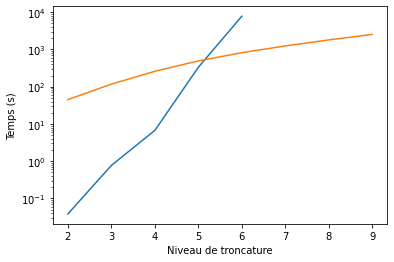

In [102]:
plt.plot(np.arange(2, len(rawsig_t)+2), np.array(rawsig_t)*10.)
plt.plot(np.arange(2, len(sigker_t)+2), np.array(sigker_t)*100.)
plt.xlabel("Niveau de troncature")
plt.ylabel("Temps (s)")
plt.yscale("log")

In [109]:
m = 4
O = np.arange(1,5)
sigs = np.array([iis.sig(trajectories[i], m) for i in range(100)])

In [114]:
true_gram = 1 + sigs@sigs.T

In [134]:
precisions = []
O = np.arange(1,5)
sigker_gram = np.zeros_like(true_gram)
for o in O:
    for i in range(len(true_gram)):
        for j in range(len(true_gram)):
            sigker_gram[i][j] = signature_kernel_higher_order(trajectories[i],trajectories[j],m,o)
    precisions.append(true_gram - sigker_gram)

In [154]:
np.max(np.abs(precisions[3]))

8.36735125631094e-10

In [146]:
diff = [np.linalg.norm(i) for i in precisions]

[38547.152853198,
 3988.160672692533,
 3.528603198044124e-09,
 3.438439939339509e-09]

([<matplotlib.axis.XTick at 0x7f120b022ca0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

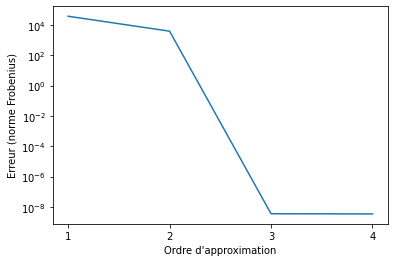

In [153]:
plt.plot(np.arange(1,5),diff)
plt.yscale("log")
plt.xlabel("Ordre d'approximation")
plt.ylabel("Erreur (norme Frobenius)")
plt.xticks(np.arange(1,5))